In [ ]:
#tiff to mat conversion



Shape after filtering: (2085, 682, 224)


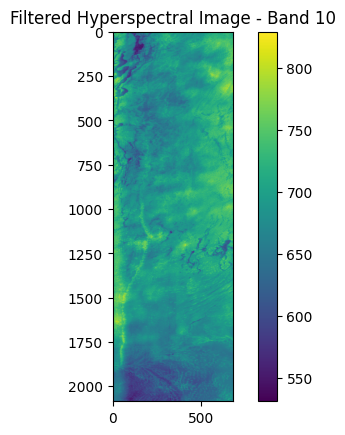

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

# Load the hyperspectral data
hyperspectral_data = scipy.io.loadmat(r"path")
hyperspectral_data = hyperspectral_data['img']  # Ensure the key is correct
height, width, bands = hyperspectral_data.shape

# Fixing the filtering issue (selecting all bands for now)
# To filter specific bands, use indexing or other criteria.
filtered_data = hyperspectral_data  # No filtering for now

print(f"Shape after filtering: {filtered_data.shape}")

# Ensure the band index is valid
band_index = 10  # Change to a valid index between 0 and bands-1
if band_index < 0 or band_index >= bands:
    raise ValueError(f"Invalid band index: {band_index}. Must be between 0 and {bands-1}.")

# Extract and display a specific band
band = filtered_data[:, :, band_index]
plt.imshow(band)
plt.colorbar()
plt.title(f'Filtered Hyperspectral Image - Band {band_index}')
plt.show()


Keys in .mat file: dict_keys(['__header__', '__version__', '__globals__', 'img', 'map'])


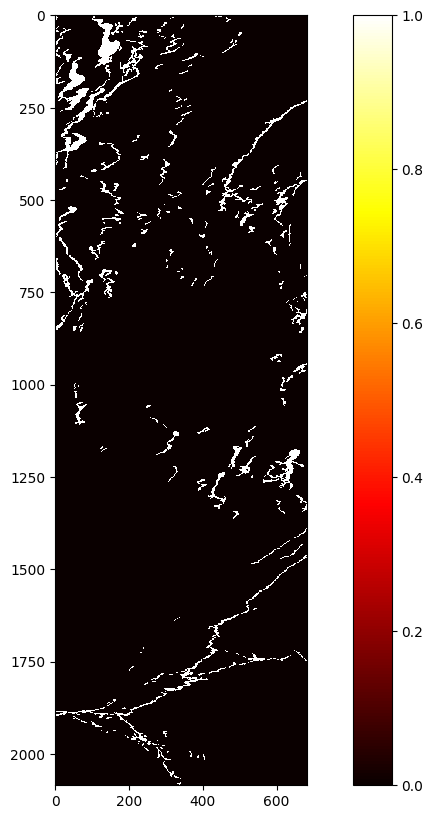

In [2]:
#Agar ground truth given ho toh
from scipy.io import loadmat

# Load the .mat file
file_path = r"C:\Users\Soham\Downloads\Hyper1.mat"  # Replace with your file path
data = loadmat(file_path)

# Inspect the keys (variables stored in the file)
print("Keys in .mat file:", data.keys())
map = data['map']
plt.figure(figsize=(12, 10))
plt.imshow(map, cmap='hot', interpolation='nearest')
plt.colorbar(label='')
#plt.title('Mean Saliency Map for Hyperspectral Data')
#plt.xlabel('Pixel X-axis')
#plt.ylabel('Pixel Y-axis')
plt.show()


Shape after filtering: (2085, 682, 224)


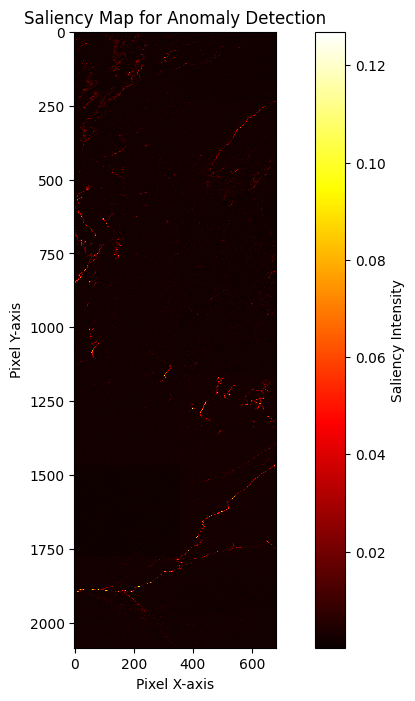

Total background vectors (DTrn): 1279767
Total anomaly vectors (DAno): 142203
Combined set (D): 1421970


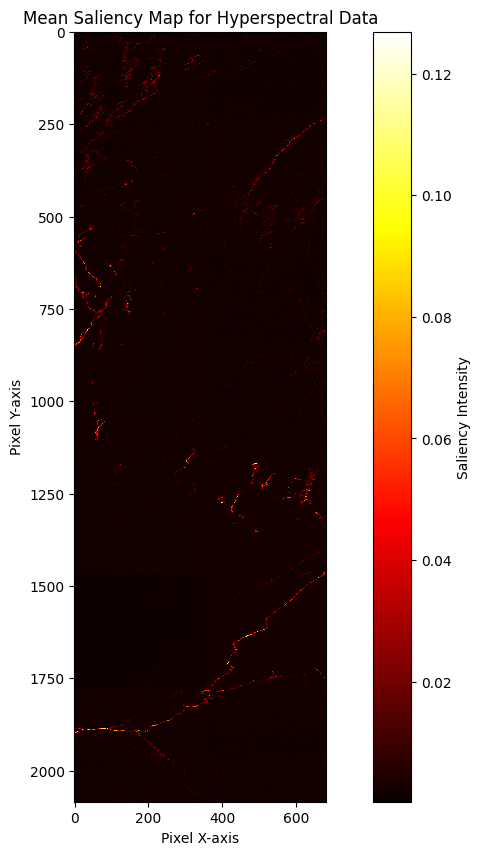

In [3]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from hyperlibrary import saliency  # Ensure this function is available

# Load the hyperspectral data
hyperspectral_data = scipy.io.loadmat(r"C:\Users\Soham\Downloads\Hyper1.mat")
hyperspectral_data = hyperspectral_data['img']  # Ensure the key matches your .mat file
height, width, bands = hyperspectral_data.shape
print(f"Shape after filtering: {height, width, bands}")

# Use all bands for now (apply filtering if needed)
filtered_data = hyperspectral_data

# Set parameters for saliency map computation
structuring_element_size = 3  # Size of the structuring element
saliency_percentile = 90  # Percentile for anomaly thresholding

# Compute saliency map and anomalies
DTrn, DAno, mean_saliency_map = saliency(
    filtered_data=filtered_data,
    structuring_element_size=structuring_element_size,
    saliency_percentile=saliency_percentile
)

# Plot the Mean Saliency Map
plt.figure(figsize=(12, 10))
plt.imshow(mean_saliency_map, cmap='hot', interpolation='nearest')
plt.colorbar(label='Saliency Intensity')
plt.title('Mean Saliency Map for Hyperspectral Data')
plt.xlabel('Pixel X-axis')
plt.ylabel('Pixel Y-axis')
plt.show()


In [ ]:
#Have to run
import torch
import torch.nn as nn
import torch.optim as optim

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


input_dim = 224  # Background feature size
#have to try reducing this 
latent_dim = 64  # Latent vector size 
batch_size = 64
epochs = 20
#try 
lr = 0.0002

# Encoder
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        return self.net(x)

# Decoder
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.net(x)

class LatentDiscriminator(nn.Module):
    def __init__(self, latent_dim):
        super(LatentDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Discriminator for reconstructed input
class ReconstructionDiscriminator(nn.Module):
    def __init__(self, input_dim):
        super(ReconstructionDiscriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize models
encoder = Encoder(input_dim, latent_dim).to(device)
decoder = Decoder(latent_dim, input_dim).to(device)
latent_discriminator = LatentDiscriminator(latent_dim).to(device)
reconstruction_discriminator = ReconstructionDiscriminator(input_dim).to(device)

mse_loss = nn.MSELoss()
bce_loss = nn.BCELoss()

opt_encoder_decoder = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr)
opt_latent_discriminator = optim.Adam(latent_discriminator.parameters(), lr=lr)
opt_reconstruction_discriminator = optim.Adam(reconstruction_discriminator.parameters(), lr=lr)



In [ ]:
#Training process (No need to run)

features_min = torch.min(torch.tensor([item[0] for item in DTrn], dtype=torch.float32).to(device), dim=0, keepdim=True)[0]
features_max = torch.max(torch.tensor([item[0] for item in DTrn], dtype=torch.float32).to(device), dim=0, keepdim=True)[0]

def normalize(features, min_val, max_val):
    return (features - min_val) / (max_val - min_val)

def denormalize(features, min_val, max_val):
    return features * (max_val - min_val) + min_val

#havent normalized the feature, have to try this as well :)
for epoch in range(epochs):
    for i in range(0, len(DTrn), batch_size):
        batch_data = DTrn[i:i + batch_size]
        features = torch.tensor([item[0] for item in batch_data], dtype=torch.float32).to(device)
        #normalized_features = normalize(features, features_min, features_max)

        # Encode 
        z_real = encoder(features)
        x_reconstructed = decoder(z_real)

        

        # Latent - Discriminator Training
        z_prior = torch.randn(batch_size, latent_dim).to(device)  # Prior Gaussian distribution
        d_z_real = latent_discriminator(z_real.detach())
        d_z_fake = latent_discriminator(z_prior)
        loss_d_z = bce_loss(d_z_real, torch.ones_like(d_z_real)) + \
                   bce_loss(d_z_fake, torch.zeros_like(d_z_fake))

        opt_latent_discriminator.zero_grad()
        loss_d_z.backward()
        opt_latent_discriminator.step()

        # Reconstruction-Discriminator Training
        recon_z_fake = decoder(z_prior)
        d_x_real = reconstruction_discriminator(features)
        d_x_fake = reconstruction_discriminator(recon_z_fake.detach())
        loss_d_x = bce_loss(d_x_real, torch.ones_like(d_x_real)) + \
                   bce_loss(d_x_fake, torch.zeros_like(d_x_fake))

        opt_reconstruction_discriminator.zero_grad()
        loss_d_x.backward()
        opt_reconstruction_discriminator.step()

        # Generator Training
        g_loss_reconstruction = mse_loss(x_reconstructed, features)  # Reconstruction loss
        g_loss_latent = bce_loss(latent_discriminator(z_real), torch.ones_like(d_z_real))  # Fool latent discriminator
        g_loss_reconstructed = bce_loss(reconstruction_discriminator(x_reconstructed), torch.ones_like(d_x_real))  # Fool reconstruction discriminator

        loss_g = g_loss_reconstruction + g_loss_latent + g_loss_reconstructed

        opt_encoder_decoder.zero_grad()
        loss_g.backward()
        opt_encoder_decoder.step()

    # Logging progress
    print(f"Epoch [{epoch + 1}/{epochs}], Loss D_Z: {loss_d_z.item():.4f}, Loss D_X: {loss_d_x.item():.4f}, Loss G: {loss_g.item():.4f}")

print("Training Complete")


In [ ]:
# Save the encoder and decoder models after training
torch.save(encoder.state_dict(), "encoder_new.pth")
torch.save(decoder.state_dict(), "decoder_new.pth")
